# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
#%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [1]:
USER_NAME = u"кузнецов".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print ("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
))

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w_i} = \frac{ -y^{(i)} * x_j  }{ 1 + e^{ y^{(i)}*g(x^{(i)}) }} + \frac{2w_j}{C} $$

## Имплементация (5 баллов)

In [32]:
# %%pycodestyle


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.fun_loss = np.zeros(max_epoch, dtype='float64')
    
    def fit(self, X, y=None):
        N = X.shape[0];
        betas = np.zeros(X.shape[1] + 1)
        y = y.copy();
        y[y == 0] = -1
        xy = np.column_stack((X, np.ones(N), y))
        for i_epoch in range(self.max_epoch):
            np.random.shuffle(xy)
            x = xy[:, :-1]
            y = xy[:,-1]   
            log = 0
            for i in range(N):
                g = np.dot(betas,x[i])
                e = np.exp(-y[i]*g)
                
                if(np.isnan(e+1)):
                    summ = y[i] * 1 * x[i];
                else:
                    summ = y[i] * e / (1. + e) * x[i];
                subtrahend = -summ + 2./self.C*betas
                betas = betas - self.alpha*subtrahend/(i_epoch + 1.)
                
                if(np.isnan(e+1)):
                    log += y[i]*g
                else:
                    log += np.log(1./(1. + e))
        
            self.fun_loss[i_epoch] = -log/N + (betas**2).sum()/self.C        
        self.betas = betas   
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y_hat = np.ones(X.shape[0])
        y_hat[self.predict_proba(X)[:,0] < 0.5] = 0
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        N = X.shape[0]
        x = np.column_stack((X, np.ones(N)))
        g = np.sum(self.betas * x, axis=1)
        y_hat_proba = np.zeros((N,2))
        e = np.exp(g)
        y_hat_proba[:, 1] = 1. / (1. + e) 
        y_hat_proba[:, 0] = 1. - y_hat_proba[:,1] 
        
        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

[ 1.08142502 -1.15381372 -4.63039674]


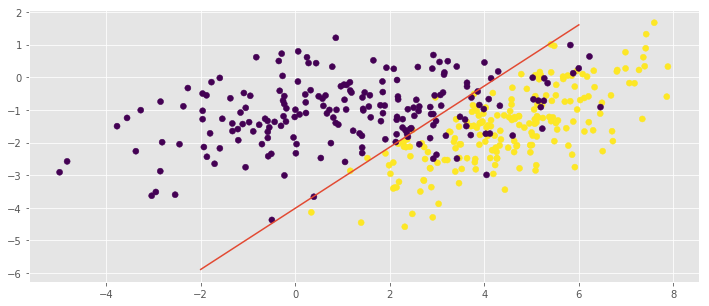

In [41]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

clf = MySGDClassifier(C=10000, alpha=0.1, max_epoch=10)
clf.fit(X,y)
print(clf.betas)
plt.scatter(X[:,0], X[:,1], c=y)
x = np.linspace(-2., 6., num=2)
plt.plot(x, -clf.betas[0]*x/clf.betas[1]-clf.betas[2]/clf.betas[1])

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [14]:
from sklearn.datasets import make_classification

In [48]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

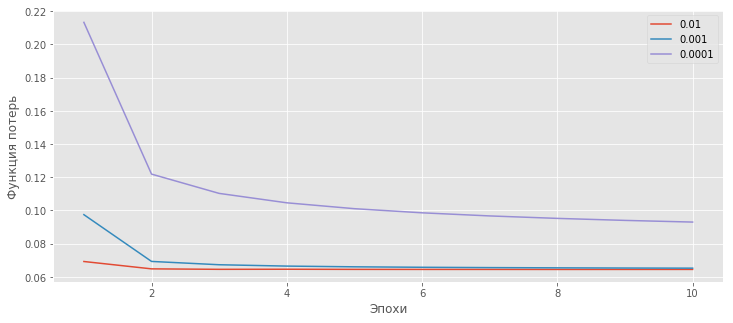

In [49]:
max_epoch = 10
x = np.arange(1, max_epoch+1)
alpha = np.array([0.01, 0.001, 0.0001])
for i in alpha:
    clf = MySGDClassifier(C=10000, alpha=i, max_epoch=max_epoch)
    clf.fit(X, y)
    plt.plot(x, clf.fun_loss,  label=str(i))
plt.legend()
plt.xlabel(u'Эпохи')
plt.ylabel(u'Функция потерь')
plt.show()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

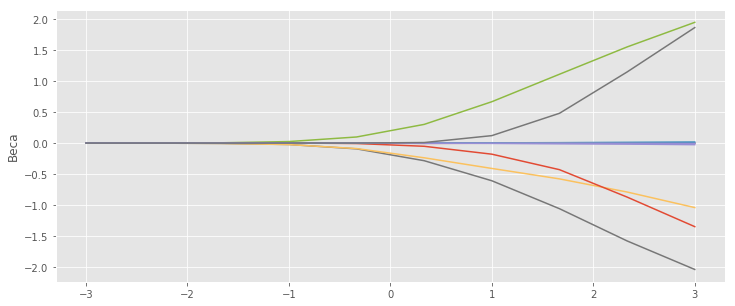

In [50]:
weigths = np.empty((X.shape[1]+1, 10))
for i, c in enumerate(np.logspace(3, -3, 10)):
    clf = MySGDClassifier(C=c, alpha=0.001, max_epoch=10)
    clf.fit(X, y)
    weigths[:, i] = clf.betas
x = np.linspace(3,-3, 10)
for i in range(X.shape[1]+1):
    plt.plot(x, weigths[i])
plt.ylabel(u'Веса')
plt.show()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [18]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk2.csv'
df_data = pd.read_csv(filepath, sep=',')


In [19]:
df_data.shape

(500000, 45)

In [20]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [21]:
#df_data.head().T

In [22]:
# Распределение классов
df_data.decision.mean()
# Примерно поровну

0.504518

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [23]:
## Youd Code Here
print("hero unique:", df_data.player_hero_card_id.unique().size)
print("opponent unique:", df_data.opponent_hero_card_id.unique().size)

df_data = pd.get_dummies(df_data, columns=['player_hero_card_id', 'opponent_hero_card_id'])


('hero unique:', 9)
('opponent unique:', 9)


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


X = df_data.iloc[:,1:]
y = df_data.iloc[:,0]

pipeline = Pipeline([
    ('1', StandardScaler()),
    ('2', MySGDClassifier(C=2, alpha=.1, max_epoch=4))
])

pipeline.fit(X,y)

Pipeline(memory=None,
     steps=[('1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('2', MySGDClassifier(C=2, alpha=0.1, max_epoch=4))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [25]:
df_list = []
for chunk in range(5,8):
    filepath = './testData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_data = pd.concat(df_list)

df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')
df_data = pd.get_dummies(df_data, columns=['player_hero_card_id', 'opponent_hero_card_id'])

test_X = df_data.iloc[:,1:]
test_y = np.loadtxt('./deprecated_testLabels.txt')

In [26]:
res = pipeline.predict(test_X)
print((test_y == res).sum() / float(test_y.shape[0]))

0.6678904


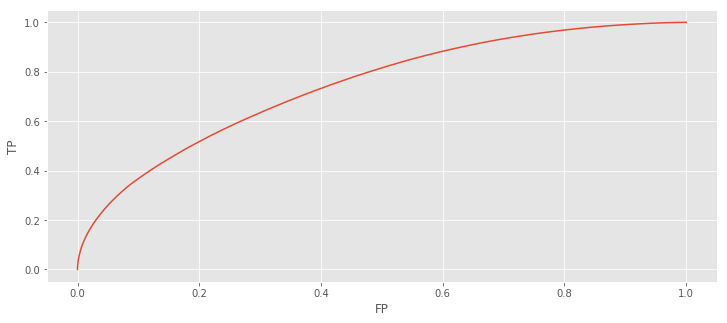

In [27]:
from sklearn.metrics import roc_curve

proba = pipeline.predict_proba(test_X)

fpr, tpr, _ = roc_curve(test_y, proba[:,0])
plt.plot(fpr, tpr)
plt.xlabel('FP')
plt.ylabel('TP')
plt.show()